In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import xgboost as xgb

from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

# color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')

In [ ]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [ ]:
us_holidays = holidays.US(years=range(2002, 2019))

holiday_dates_hourly = pd.DataFrame(columns=["Holiday"])

for holiday_date in us_holidays:
    hourly_timestamps = pd.date_range(
        start=pd.Timestamp(holiday_date).replace(hour=0, minute=0, second=0),
        end=pd.Timestamp(holiday_date).replace(hour=23, minute=0, second=0),
        freq='H'
    )

    holiday_dates_hourly = pd.concat([holiday_dates_hourly, pd.DataFrame(hourly_timestamps, columns=["Holiday"])], ignore_index=True)

holiday_dates_hourly.set_index("Holiday", inplace=True)

In [ ]:
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['IsHoliday'] = df.index.isin(holiday_dates_hourly.index).astype(bool)

    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)

    return df

df = create_features(df)

In [ ]:
df

In [ ]:
df = df.query('PJME_MW > 19_000').copy()

In [ ]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'IsHoliday', 'lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'

train_idx = df.index < '01-01-2015'
test_idx = df.index >= '01-01-2015'

train = df.iloc[train_idx]
test = df.iloc[test_idx]

train = create_features(train)
test = create_features(test)

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7, 9],
}

# Initialize the LightGBM Regressor
reg = LGBMRegressor()

# Define custom scoring functions for RMSE and MAPE
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
mape_scorer = make_scorer(lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100, greater_is_better=False)

# Create the Grid Search object
grid_search = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    cv=tss,
    scoring={'rmse': rmse_scorer, 'mape': mape_scorer},
    refit='rmse',  # Refit using RMSE for the best model
    n_jobs = -1
)

grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results_lgbm = grid_search.cv_results_

# Extract RMSE and MAPE scores for training and validation sets
# train_rmse_lgbm = -cv_results_lgbm['mean_train_rmse']
val_rmse_lgbm = -cv_results_lgbm['mean_test_rmse']

# train_mape_lgbm = -cv_results_lgbm['mean_train_mape']
val_mape_lgbm = -cv_results_lgbm['mean_test_mape']



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 113911, number of used features: 10
[LightGBM] [Info] Start training from score 32291.350282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


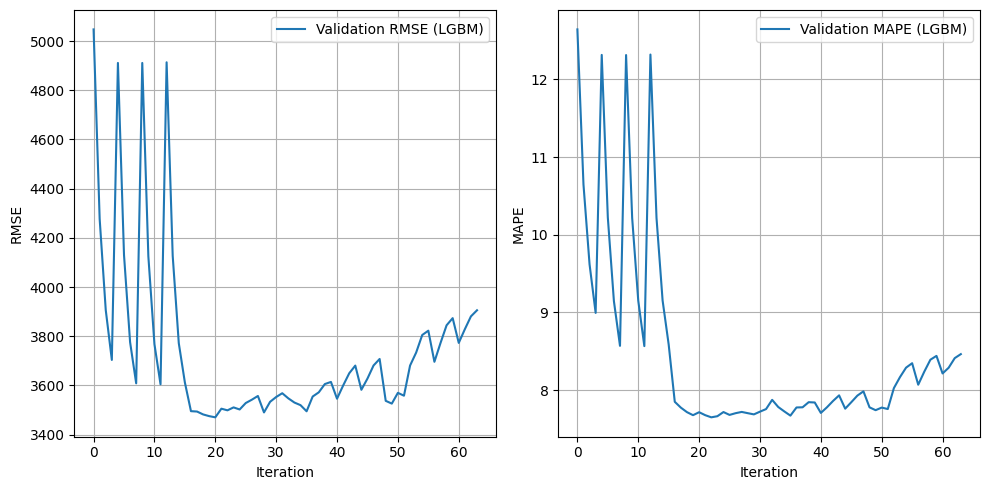

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot RMSE
plt.subplot(1, 2, 1)
# plt.plot(train_rmse_lgbm, label='Training RMSE (LGBM)')
plt.plot(val_rmse_lgbm, label='Validation RMSE (LGBM)')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.legend()

# Plot MAPE
plt.subplot(1, 2, 2)
# plt.plot(train_mape_lgbm, label='Training MAPE (LGBM)')
plt.plot(val_mape_lgbm, label='Validation MAPE (LGBM)')
plt.xlabel('Iteration')
plt.ylabel('MAPE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(cv_results_lgbm.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse', 'split3_test_rmse', 'split4_test_rmse', 'mean_test_rmse', 'std_test_rmse', 'rank_test_rmse', 'split0_test_mape', 'split1_test_mape', 'split2_test_mape', 'split3_test_mape', 'split4_test_mape', 'mean_test_mape', 'std_test_mape', 'rank_test_mape'])


In [ ]:
best_lgbm_model = grid_search.best_estimator_
best_lgbm_model.booster_.save_model('best_lgbm_model.txt')


In [ ]:

cv_results_df = pd.DataFrame.from_dict(grid_search.cv_results_)

# Save the CV results to a CSV file
cv_results_df.to_csv('grid_search_cv_results_lgbm.csv', index=False)


In [ ]:
best_params_lgbm = grid_search.best_params_
best_scores_lgbm = grid_search.best_score_


results_dict = {
    'best_params_lgbm': best_params_lgbm,
    'best_scores_lgbm': best_scores_lgbm
}

import json
with open('grid_search_results_lgbm.json', 'w') as file:
    json.dump(results_dict, file, indent=4)  # Save the dictionary to a JSON file


In [ ]:
base_estimator_params = grid_search.best_estimator_.get_params()
base_estimator_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}